# Fingerprint distances between structures for the same kinase

We investigate the ranges of fingerprint distances for each kinase pair:

- Compare the fingerprint distance distribution for intra-kinase pairs and inter-kinase pairs
- For the kinase pairs with highest structure pair coverage, show the range of fingerprint distances (consider minimum or median for structure-to-kinase mapping)
- Generate `kissim` kinase matrix for kinase subset investigated in the paper ["Analyzing Kinase Similarity in Small Molecule and Protein Structural Space to Explore the Limits of Multi-Target Screening"](https://www.mdpi.com/1420-3049/26/3/629)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/dfg_in"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = DATA / "fingerprint_distances.csv"

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [10]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 257
Number of structures: 4055


In [11]:
structure_distances = fingerprint_distance_generator.data
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,2,7,EphA7,ITK,0.066628,0.984000
1,2,8,EphA7,ITK,0.065828,0.954000
2,2,9,EphA7,ITK,0.097455,0.985333
3,2,11,EphA7,ITK,0.077680,0.977333
4,2,12,EphA7,ITK,0.067287,0.962000


### Add DFG conformation

In [12]:
%%time
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])

CPU times: user 50.5 s, sys: 285 ms, total: 50.8 s
Wall time: 50.8 s


### Filter distances by coverage cutoff

In [13]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2,distance_filtered
0,2,7,EphA7,ITK,0.066628,0.984000,in,in,0.066628
1,2,8,EphA7,ITK,0.065828,0.954000,in,in,0.065828
2,2,9,EphA7,ITK,0.097455,0.985333,in,in,0.097455
3,2,11,EphA7,ITK,0.077680,0.977333,in,in,0.077680
4,2,12,EphA7,ITK,0.067287,0.962000,in,in,0.067287


In [14]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [15]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 8219485
Structure pairs not-NaN: 8217114


## Structure distances

### Structure distance distributions for different subsets

- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

#### Without coverage cutoff

In [16]:
structure_distances_df = pd.DataFrame(
    {
        "all": structure_distances["distance"],
        "intra-kinase": structure_distances[
            structure_distances["kinase.1"] == structure_distances["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances[
            ~(structure_distances["kinase.1"] == structure_distances["kinase.2"])
        ]["distance"],
    }
)

In [17]:
structure_distances_df.notna().sum()

all             8219485
intra-kinase     194868
inter-kinase    8024617
dtype: int64

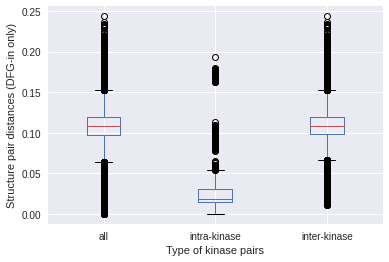

In [18]:
fig, ax = plt.subplots(1, 1)
structure_distances_df.plot(kind="box", ax=ax)
ax.set_xlabel("Type of kinase pairs")
ax.set_ylabel("Structure pair distances (DFG-in only)")
fig.savefig(
    HERE / "../../notebooks/figures/kissim_discriminating_kinases.png",
    dpi=300,
    bbox_inches="tight",
)

In [19]:
structure_distances_df.describe()

,all,intra-kinase,inter-kinase
count,8.219485e+06,194868.000000,8.024617e+06
mean,1.088478e-01,0.022557,1.109432e-01
std,2.487666e-02,0.011506,2.110569e-02
min,0.000000e+00,0.000000,1.051971e-02
25%,9.734394e-02,0.014354,9.820983e-02
50%,1.077919e-01,0.018878,1.082469e-01
75%,1.194061e-01,0.030421,1.197786e-01
max,2.435807e-01,0.193746,2.435807e-01


#### With coverage cutoff

In [20]:
structure_distances_filtered_df = pd.DataFrame(
    {
        "all": structure_distances_filtered["distance"],
        "intra-kinase": structure_distances_filtered[
            structure_distances_filtered["kinase.1"] == structure_distances_filtered["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances_filtered[
            ~(structure_distances_filtered["kinase.1"] == structure_distances_filtered["kinase.2"])
        ]["distance"],
    }
)

In [21]:
structure_distances_filtered_df.notna().sum()

all             8217114
intra-kinase     194858
inter-kinase    8022256
dtype: int64

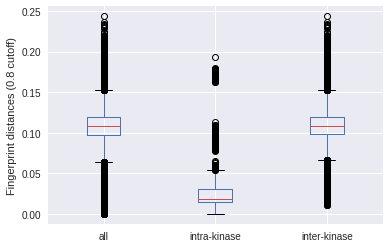

In [22]:
fig, axes = plt.subplots(1, 1)
structure_distances_filtered_df.plot(kind="box", ax=axes)
axes.set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)")
fig.savefig(HERE / "../../notebooks/figures/kissim_discriminates_kinases.png", dpi=300)

In [23]:
structure_distances_filtered_df.describe()

,all,intra-kinase,inter-kinase
count,8.217114e+06,194858.000000,8.022256e+06
mean,1.088407e-01,0.022556,1.109365e-01
std,2.487251e-02,0.011506,2.110035e-02
min,0.000000e+00,0.000000,1.051971e-02
25%,9.734091e-02,0.014354,9.820709e-02
50%,1.077875e-01,0.018878,1.082427e-01
75%,1.193981e-01,0.030422,1.197705e-01
max,2.435807e-01,0.193746,2.435807e-01


### Per kinase distributions

How robust are structure distances within kinase pairs?

#### All kinase pairs

In [24]:
data = structure_distances_filtered[["kinase.1", "kinase.2", "distance"]].groupby(
    ["kinase.1", "kinase.2"]
)

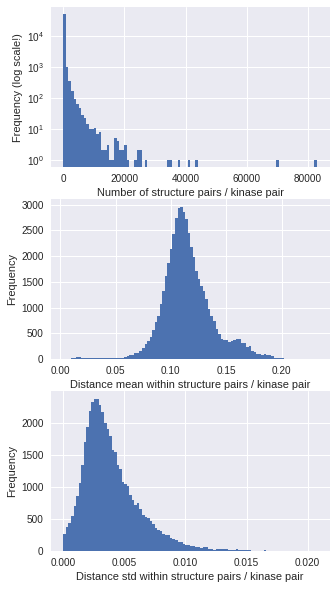

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data.size().plot(ax=axes[0], kind="hist", logy=True, style=".", bins=100)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data.mean().squeeze().plot(ax=axes[1], kind="hist", style=".", bins=100)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data.std().squeeze().plot(ax=axes[2], kind="hist", logy=False, style=".", bins=100)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [26]:
print("size == 1: ", data.size()[data.size() == 1].shape[0])
print("size < 5: ", data.size()[data.size() < 5].shape[0])
print("size < 10: ", data.size()[data.size() < 10].shape[0])
print("size < 100: ", data.size()[data.size() < 100].shape[0])
print("size < 1000: ", data.size()[data.size() < 1000].shape[0])
print("size < 10000: ", data.size()[data.size() < 10000].shape[0])
print("size: ", data.size().shape[0])

size == 1:  4297
size < 5:  13554
size < 10:  20219
size < 100:  41384
size < 1000:  50060
size < 10000:  51539
size:  51603


In [27]:
data.mean().describe()

,distance
count,51603.000000
mean,0.114940
std,0.022966
min,0.002870
25%,0.101765
50%,0.112291
75%,0.125988
max,0.231978


In [28]:
data.std().describe()

,distance
count,4.730600e+04
mean,3.905577e-03
std,2.292019e-03
min,5.304269e-07
25%,2.329184e-03
50%,3.403782e-03
75%,5.011365e-03
max,2.077105e-02


#### Most frequent kinase pairs (all conformations)

In [29]:
data = structure_distances_filtered.groupby(["kinase.1", "kinase.2"])

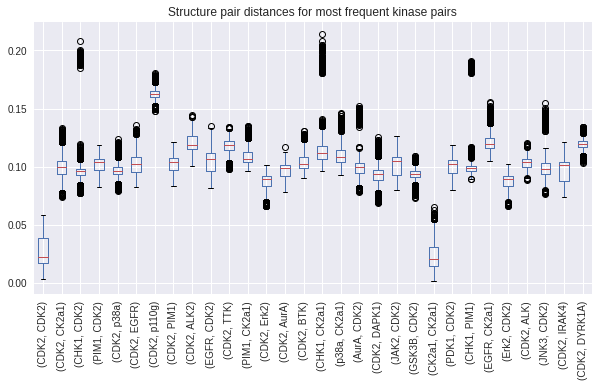

In [30]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

In [31]:
data_min = data.min()

In [32]:
print("Minimum pair has same conformations")
print(data_min[data_min["dfg.1"] == data_min["dfg.2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has same conformations
100.0


In [33]:
print("Minimum pair has different conformations")
print(data_min[data_min["dfg.1"] != data_min["dfg.2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has different conformations
0.0


#### Most frequent kinase pairs (DFG-in conformations only)

In [34]:
structure_distances_filtered_dfgin = structure_distances_filtered[
    (structure_distances_filtered["dfg.1"] == "in")
    & (structure_distances_filtered["dfg.2"] == "in")
]
structure_distances_filtered.shape, structure_distances_filtered_dfgin.shape

((8217114, 9), (8217114, 9))

In [35]:
data = structure_distances_filtered_dfgin.groupby(["kinase.1", "kinase.2"])

<AxesSubplot:>

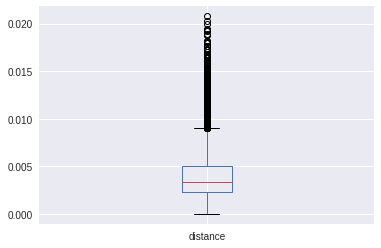

In [36]:
data["distance"].std().plot(kind="box")

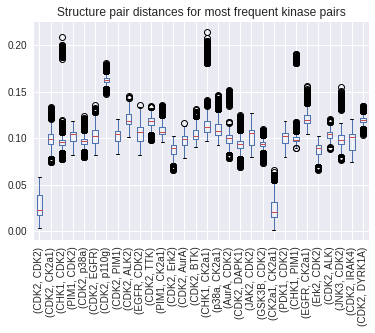

In [37]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1)
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs")
fig.savefig(
    HERE / f"../../notebooks/figures/figX_structure_distances_per_kinase_pair_top{ntop}.pdf",
    bbox_inches="tight",
)

## Structure > kinase distances (median)

In [38]:
kinase_distances = structure_distances.groupby(["kinase.1", "kinase.2"]).median().reset_index()
kinase_distances.head()

,kinase.1,kinase.2,structure.1,structure.2,distance,bit_coverage,distance_filtered
0,AAK1,AAK1,3833.0,7156.0,0.018130,0.992667,0.018130
1,AAK1,ACK,6679.0,13290.0,0.115615,0.988000,0.115615
2,AAK1,ADCK3,6679.0,9121.0,0.149496,0.983667,0.149496
3,AAK1,AKT1,6679.0,9868.0,0.112232,0.992000,0.112232
4,AAK1,ALK,3833.0,6661.0,0.118932,0.981667,0.118932


In [39]:
kinase_distances_filtered = kinase_distances[kinase_distances["distance_filtered"].notna()]

In [40]:
print(f"Kinase pairs: {kinase_distances.shape[0]}")
print(f"Kinase pairs not-NaN: {kinase_distances_filtered.shape[0]}")

Kinase pairs: 51637
Kinase pairs not-NaN: 51603


## Kinase matrix

### All distances

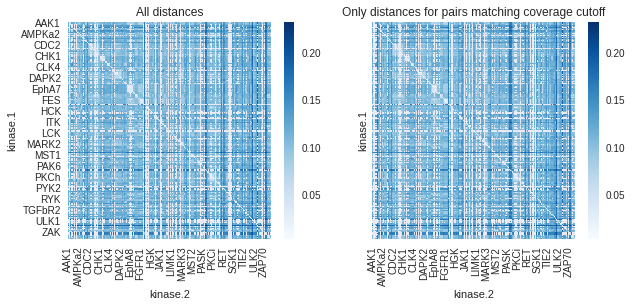

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("All distances")
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance_filtered")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Only distances for pairs matching coverage cutoff");

In [42]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [43]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        kinase_distances.shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        kinase_distances_filtered.shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,4055,4055
Number of structure pairs (theory),8223540,8223540
Number of structure pairs (experimental),8219485,8217114
Number of kinases,257,257
Number of kinase pairs (theory),33153,33153
Number of kinase pairs (experimental),51637,51603


## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [44]:
from itertools import combinations_with_replacement

In [45]:
KINASES_KLIFS_TO_PAPER = {
    "EGFR": "EGFR",
    "ErbB2": "ErbB2",
    "KDR": "VEGFR2",
    "p110a": "PI3K",
    "BRAF": "BRAF",
    "CDK2": "CDK2",
    "LCK": "LCK",
    "MET": "MET",
    "p38a": "p38a",
}

In [46]:
example_kinases = list(KINASES_KLIFS_TO_PAPER.keys())
print(example_kinases)
example_kinase_pairs = [i for i in combinations_with_replacement(example_kinases, 2)]

['EGFR', 'ErbB2', 'KDR', 'p110a', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']


In [47]:
example_kinase_distances = kinase_distances_filtered[
    kinase_distances_filtered.apply(
        lambda x: (x["kinase.1"], x["kinase.2"]) in example_kinase_pairs, axis=1
    )
]

In [48]:
example_kinase_distances.shape

(39, 7)

In [49]:
example_kinase_matrix = example_kinase_distances.pivot("kinase.1", "kinase.2", "distance")
example_kinase_matrix = example_kinase_matrix.loc[example_kinases, example_kinases]
example_kinase_matrix

kinase.2,EGFR,ErbB2,KDR,p110a,BRAF,CDK2,LCK,MET,p38a
kinase.1,,,,,,,,,
EGFR,0.024683,0.04848,0.081654,0.160060,0.109625,0.106297,0.089542,0.099055,0.109133
ErbB2,NaN,NaN,0.093437,0.174852,0.116069,0.116622,NaN,0.110131,0.118156
KDR,NaN,NaN,0.019302,0.167682,0.101487,0.100523,NaN,0.083933,0.097439
p110a,NaN,NaN,NaN,0.019049,0.150348,0.168340,NaN,0.171784,0.158867
BRAF,NaN,NaN,NaN,NaN,0.030108,0.102891,NaN,0.111337,0.113941
CDK2,NaN,NaN,NaN,NaN,NaN,0.022636,NaN,0.101397,0.096415
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.009633,0.098909,0.106913
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021256,0.116346
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025735


In [50]:
example_kinase_matrix.columns = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.columns]
example_kinase_matrix.index = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.index]
example_kinase_matrix

,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
EGFR,0.024683,0.04848,0.081654,0.160060,0.109625,0.106297,0.089542,0.099055,0.109133
ErbB2,NaN,NaN,0.093437,0.174852,0.116069,0.116622,NaN,0.110131,0.118156
VEGFR2,NaN,NaN,0.019302,0.167682,0.101487,0.100523,NaN,0.083933,0.097439
PI3K,NaN,NaN,NaN,0.019049,0.150348,0.168340,NaN,0.171784,0.158867
BRAF,NaN,NaN,NaN,NaN,0.030108,0.102891,NaN,0.111337,0.113941
CDK2,NaN,NaN,NaN,NaN,NaN,0.022636,NaN,0.101397,0.096415
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.009633,0.098909,0.106913
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021256,0.116346
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025735


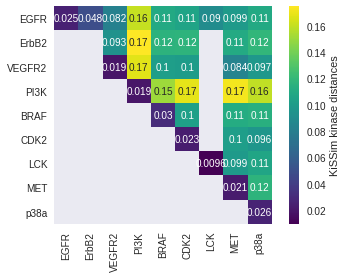

In [51]:
sns.heatmap(
    example_kinase_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "KiSSim kinase distances"},
    cmap="viridis",
)
plt.show()

Compare to paper (shows similarities; not distances; __so think values inverse__):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.